In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from researchlib.single_import import *

In [3]:
train_loader = FromVisionDataset(vision.CIFAR10(True), batch_size=256)
test_loader = FromVisionDataset(vision.CIFAR10(False), batch_size=256)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Model
model = builder([
    SENet18(input_dim=3),
    nn.LogSoftmax(-1),
])

# Learning
runner = Runner(model, train_loader, test_loader, optimizer='adam', loss_fn='nll')

In [5]:
runner.init_model()

Init xavier_normal: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Init xavier_normal: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Init xavier_normal: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Init xavier_normal: Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
Init xavier_normal: Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
Init xavier_normal: PreActBlock(
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
  (fc2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
)
Init xavier_normal: PreActBlock(
  (bn1): BatchNorm2d(64, eps=

In [6]:
runner.fit(2, 1e-3)

  Epochs    train_loss    train_acc      val_loss      val_acc    
    1*        1.6108        0.4441        1.2385        0.5610    


    2         0.9055        0.6830        0.7626        0.7309    



0.7567012652754783 tensor(0.7309, device='cuda:0')


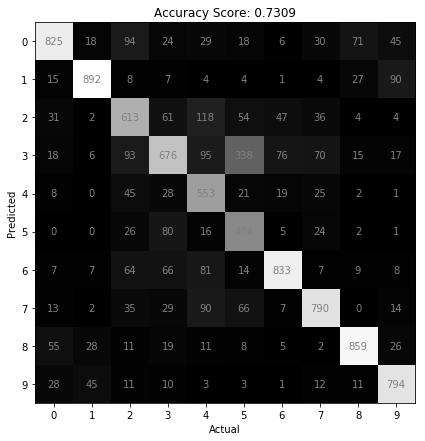

In [7]:
runner.validate(metrics=[ConfusionMatrix(plot=True, classes=10)])

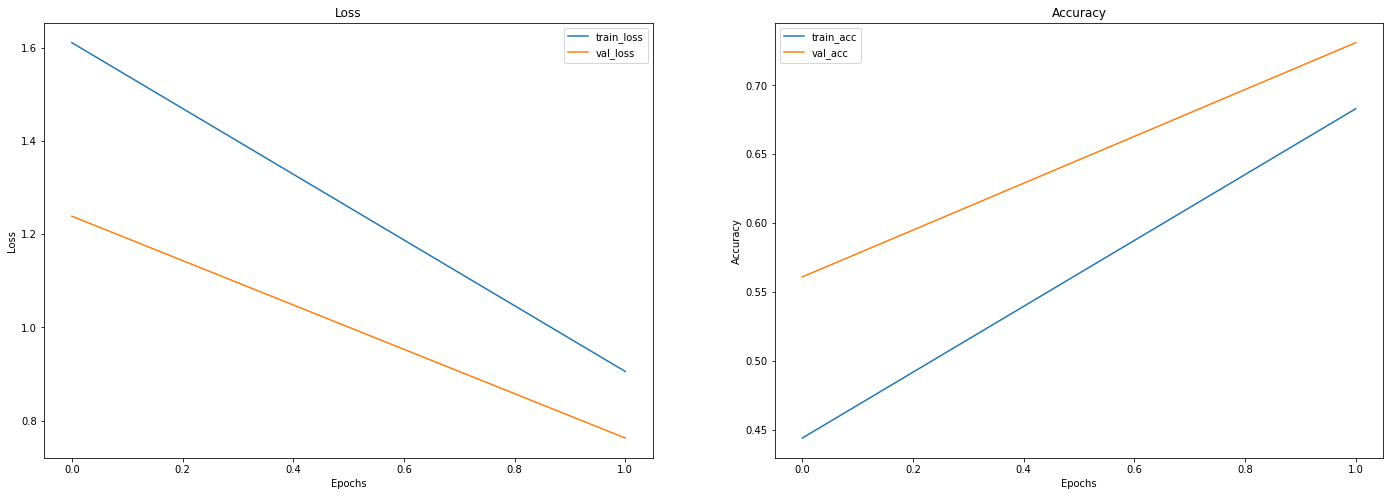

In [8]:
runner.history(plot=True)